In [243]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import math
import imutils
import pandas as pd
from tqdm.auto import trange, tqdm
# import enlighten

In [244]:
def read_image(path):
    img = cv2.imread(path)
    gray_eye_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray_eye_image

In [245]:
img = read_image(f'D:/Users/jimyj/Desktop/TAIST/Thesis/Source_Code/Iris-Dataset/CASIA-IrisV2/device1/0001/0001_000.bmp')

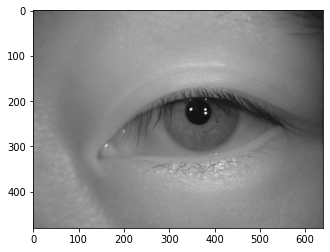

In [246]:
plt.imshow(img, cmap='gray')

In [247]:
from PIL import Image
import random

In [248]:
def rotate_image(img):
    # Open the image file
    image = img
    
    reference_color = image.getpixel((image.size[0]/2, 0))

    # Rotate the image by a random degree
    angle = random.randint(0, 90)
    rotated_image = image.rotate(angle, expand=True)

    # Replace black pixels with reference color
    rotated_array = np.array(rotated_image)
    rotated_array[rotated_array == 0] = reference_color
    rotated_image = Image.fromarray(rotated_array)
    
    # Crop the image to make it rectangular
    width, height = rotated_image.size
    if width > height:
        cropped_image = rotated_image.crop(((width - height) // 2, 0, (width + height) // 2, height))
    else:
        cropped_image = rotated_image.crop((0, (height - width) // 2, width, (height + width) // 2))

    return cropped_image

In [249]:
def detect_corners(image):
    # Load the eye cascade classifier
    eye_cascade = cv2.CascadeClassifier("model/haarcascade_eye_tree_eyeglasses.xml")

    # Detect eyes in the image
    eyes = eye_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5)

    # Draw rectangles around the eyes and corners
    img_copy = np.array(image)
    if len(eyes) > 0:
        for (x, y, w, h) in eyes:
            cv2.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        plt.imshow(img_copy, cmap='gray')
    else:
        print("Eye not found")

In [250]:
rotated_img = np.array(rotate_image(Image.fromarray(img)))
plt.imshow(rotated_img, cmap='gray')
detect_corners(rotated_img)

In [251]:
import dlib

In [252]:
plt.imshow(rotated_img, cmap='gray')

In [253]:
def find_pupil_new(img):
    img = cv2.medianBlur(img, 15)
    img = cv2.Canny(img, 0, 50)
    param1 = 200  # 200
    param2 = 120  # 150
    decrement = 1
    circles = None
    while circles is None and param2 > 20:
        # HoughCircles
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 1,
                                   param1=param1, param2=param2,
                                   minRadius=20, maxRadius=80)

        if circles is not None:
            break

        param2 -= decrement

    if circles is None:
        return None, None, None

    return circles.astype(int)[0][0]

In [263]:
def localization(img, N=400, alpha=1.6, beta=500, gamma=0.05):
    # DoG = cv2.GaussianBlur(img, (3, 3), 0) - cv2.GaussianBlur(img, (25, 25), 0)
    gaussian1 = cv2.GaussianBlur(img, (3, 3), 0)
    median1 = cv2.medianBlur(gaussian1, 31)
    dilated = cv2.dilate(median1, np.ones((3, 3), np.uint8), iterations=5)
    eroted = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=5)
    # median2 = cv2.medianBlur(median1, 5)
    # eroted = cv2.erode(dilated, np.ones((5, 5), np.uint8), iterations=1)
    result = eroted

    x, y, rad = find_pupil_new(img)

    if x is None:
        x, y = 350, 250

    s = np.linspace(0, 2*np.pi, 400)
    c = x + 250*np.cos(s)
    r = y + 250*np.sin(s)
    init = np.array([r, c]).T

    snake = active_contour(result, init, alpha=alpha, beta=beta, gamma=gamma)

    return init, snake, (x, y, rad), result

Text(0.5, 1.0, 'Mask Iris')

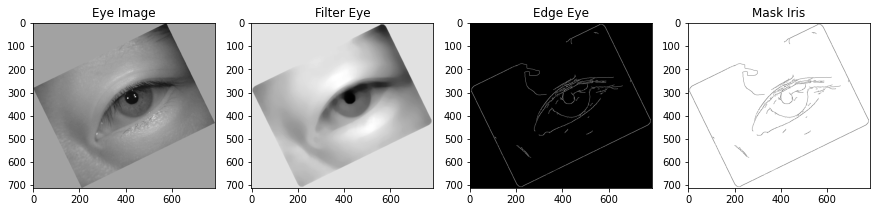

In [273]:
_, snake, circles, result = localization(
                rotated_img, N=400, alpha=0.1, beta=5, gamma=0.05)

pupil_circle = circles
iris_circle = np.flip(np.array(snake).astype(int), 1)
mask = np.zeros_like(rotated_img)
mask[snake[:,0].astype(int), snake[:,1].astype(int)] = 255

edges = cv2.Canny(result, 0, 20)

contours, _ = cv2.findContours(mask, 2,2)
for i in range(len(contours)):
    cv2.drawContours(mask, contours, i, (255,255,255), 3, cv2.LINE_8)
    
contours, hierarchies = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for cnt in contours:
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    
mask = cv2.bitwise_not(mask)
    
plt.figure(figsize=(15,10))
plt.subplot(1,4,1),plt.imshow(rotated_img,cmap = 'gray')
plt.title('Eye Image')
plt.subplot(1,4,2),plt.imshow(result,cmap = 'gray')
plt.title('Filter Eye')
plt.subplot(1,4,3),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Eye')
plt.subplot(1,4,4),plt.imshow(mask,cmap = 'gray')
plt.title('Mask Iris')